In [1]:
import tensorflow as tf
from tensorflow import keras  
import numpy as np
import pandas as pd
from numpy.random import randint
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

at_home = True

if at_home == True:
    checkpoint1_path = 'model_weights_home/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_home/cp-{epoch:04d}.ckpt'
else:
    checkpoint1_path = 'model_weights_uni/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_uni/cp-{epoch:04d}.ckpt'

2023-03-10 18:48:17.947188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

image classes
dataframe
shuffling


In [3]:
# class balancing everything
clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))
print('\n',np.min(num_class))

for i in clist:
    print(i)
    df_other = df[df['class']==str(i)].sample(n=np.min(num_class), random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])
    
clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))

# class balancing with only crater and other 
'''clist = [0,1]
for i in clist:
    df_other = df[df['class']==str(i)].sample(n=1250,random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])

clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))'''

61054
4900
1141
2331
1750
231
1148
476

 231
0
1
2
3
4
5
6
7
231
231
231
231
231
231
231
231


'clist = [0,1]\nfor i in clist:\n    df_other = df[df[\'class\']==str(i)].sample(n=1250,random_state=1)\n    df = df.drop(df.index[(df["class"] == str(i))])\n    df = pd.concat([df_other,df])\n\nclist = [i for i in range(0,8)]\nnum_class = []\nfor i in clist:\n    num_class.append(len(df[df[\'class\']==str(i)]))\n    print(len(df[df[\'class\']==str(i)]))'

In [4]:
print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

traintestsplit
image generator
batching
Found 739 validated image filenames belonging to 8 classes.
Found 370 validated image filenames belonging to 8 classes.
Found 739 validated image filenames belonging to 8 classes.


In [5]:
print(df)

                                filename class
72834   ESP_049651_1050_RED-0070-brt.jpg     7
72932   PSP_003470_0930_RED-0113-brt.jpg     7
60973  PSP_003470_0930_RED-0040-r270.jpg     7
49092   ESP_049651_1050_RED-0090-r90.jpg     7
36531    PSP_003470_0930_RED-0116-fv.jpg     7
...                                  ...   ...
27890  ESP_036575_2075_RED-0152-r180.jpg     0
37462    PSP_008462_1440_RED-0357-fv.jpg     0
54649       ESP_026472_1410_RED-0397.jpg     0
64935  ESP_017001_1805_RED-0311-r270.jpg     0
42398   ESP_017770_1990_RED-0406-brt.jpg     0

[1848 rows x 2 columns]


2023-03-10 18:48:22.104537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 18:48:22.105927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-03-10 18:48:22.147729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-03-10 18:48:22.147792: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen 

4


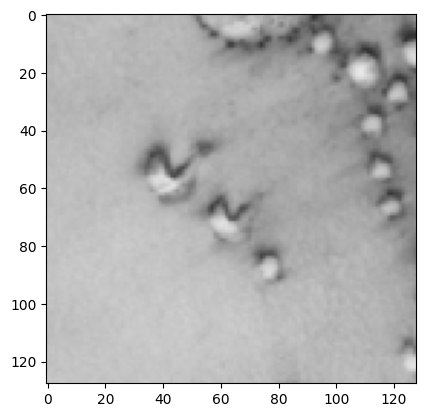

In [6]:
resize = 128
image_test = tf.image.resize(
    train_ds[0][0][0],
    [resize,resize])
print(np.argmax(train_ds[0][1][0]))
plt.imshow(image_test)

In [ ]:
BatchSize       = batchsize
Nepochs         = 75
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(64, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.35))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.45))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.55))
model.add(keras.layers.Dense(8, activation='softmax'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")

loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint1_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  75 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (0, 128, 128, 3)          0         
                                                                 
 conv2d (Conv2D)             (0, 128, 128, 64)         1792      
                                                                 
 max_pooling2d (MaxPooling2D  (0, 64, 64, 64)          0         
 )                                                               
                                                                 


2023-03-10 18:48:25.033071: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2023-03-10 18:48:27.263890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


1/6 [====>.........................] - ETA: 20s - loss: 2.0765 - accuracy: 0.1094

2023-03-10 18:48:27.795052: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2023-03-10 18:48:29.996845: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


2/6 [=========>....................] - ETA: 10s - loss: 4.7666 - accuracy: 0.0938

2023-03-10 18:48:30.498542: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 415236096 exceeds 10% of free system memory.


6/6 [==============================] - ETA: 0s - loss: 3.3810 - accuracy: 0.1191
Epoch 1: saving model to model_weights_home/cp-0001.ckpt
6/6 [==============================] - 25s 4s/step - loss: 3.3810 - accuracy: 0.1191 - val_loss: 2.0795 - val_accuracy: 0.1286
Epoch 2/75
6/6 [==============================] - ETA: 0s - loss: 2.0786 - accuracy: 0.1664
Epoch 2: saving model to model_weights_home/cp-0002.ckpt
6/6 [==============================] - 24s 4s/step - loss: 2.0786 - accuracy: 0.1664 - val_loss: 2.0790 - val_accuracy: 0.1123
Epoch 3/75
6/6 [==============================] - ETA: 0s - loss: 2.0663 - accuracy: 0.1664
Epoch 3: saving model to model_weights_home/cp-0003.ckpt
6/6 [==============================] - 25s 4s/step - loss: 2.0663 - accuracy: 0.1664 - val_loss: 2.0505 - val_accuracy: 0.1516
Epoch 4/75
6/6 [==============================] - ETA: 0s - loss: 2.0537 - accuracy: 0.1705
Epoch 4: saving model to model_weights_home/cp-0004.ckpt
6/6 [=============================

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest) 
loss, acc = model.evaluate(test_ds)

In [ ]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

In [ ]:
# summarize history for loss
print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
print("  loss (test)      = ", history.history['val_loss'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(test_ds)

In [ ]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 12))
class_list = [i for i in range(0,8)]

rand_list = list(randint(0,1,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,1,2,3,4,5,6,7],prediction)
            axes[y][j].bar([0,1,2,3,4,5,6,7],k,alpha=0.5)
            axes[y][j].grid(alpha=0.5, linestyle='--', color='gray')
            axes[y][j].set_ylim(0,np.max(prediction)*2)
            axes[y][j].set_xticks([0,1,2,3,4,5,6,7])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break

In [ ]:
abs_predictions = np.argmax(predictions,axis=1)
test_df['models class'] = abs_predictions
test_df.head(20)
print(len(abs_predictions))

In [ ]:
# for some reason class was a column of strings... took ages to figure that out
test_df['class'] = test_df['class'].astype(int)
class_list = [i for i in range(0,8)]

accuracy_list = []
for i in class_list:
    
    df_0 = test_df.loc[test_df['class'] == i]
    num_identical = sum(df_0['class'] == df_0['models class'])
    num_rows = len(df_0)
    percent_identical = num_identical / num_rows * 100
    accuracy_list.append(percent_identical)

print(accuracy_list)
plt.bar(class_list,accuracy_list)
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.xlabel('classes')
plt.ylabel('prediction accuracy percentage')

### changing to is/is not:[dune]

In [ ]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

# Replace non-dune class labels with 0 & again with the string values for class. whyyyyyyyyyyy
print('reformatting')
df['class'] = df['class'].astype(int)
df.loc[~df['class'].isin([2, 4]), 'class'] = 0
df.loc[df['class'].isin([2, 4]), 'class']  = 1
df['class'] = df['class'].astype(str)

clist = [0,1]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(f'length of class: {i}',len(df[df['class']==str(i)]))
print('min class count',np.min(num_class))

for i in clist:
    df_other = df[df['class']==str(i)].sample(n=np.min(num_class), random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])
    
clist = [0,1]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(f'length of class: {i}',len(df[df['class']==str(i)]))

In [ ]:
print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

In [ ]:
BatchSize       = batchsize
Nepochs         = 10
resize = 128
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(16, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.10))

model.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.15))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(2, activation='sigmoid'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint2_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) 
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

In [ ]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

In [ ]:
print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
old_predictions = model.predict(test_ds)

In [ ]:
predictions = []
for i in old_predictions:
    predictions.append(i[1])
print(predictions)

In [ ]:
fpr, tpr, _ = roc_curve(test_ds.classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.7f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.grid(alpha=0.5, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()